# CSE-891 PROJECT: IDENTIFYING FACTORS CRITICAL FOR RESULTS IN THE ENGLISH PREMIER LEAGUE GAMES AND FINDING PLAYERS THAT FIT IT

I am an avid soccer fan - I play and watch as much as I can. I love the premier league and watch it with fascination. I am not a supporter of any club and just watch teams that catch my eye. For this project, I wanted to see whether I could use implicit statistics (i.e. tackles, interceptions, cards etc.) to understand the outcome. The approach is as follows:
1. Gather premier league game data from 2015-2017(Current) seasons. Gather data for each side per game.
2. Use classification/regression techniques to predict whether a team will allow gaols or not. Motivation is that a clean sheet guarentees a result.
3. Use classification/regression techniques to game outcome - loss vs draw/win
4. Use the outcome model to identify players that best fit

### IMPORTING NECESSARY LIBRARIES

I first import all the necessary libraries required for this notebook. As different parts of the notebook was completed, the libraries were consolidated in this location

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import json
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

The main objectives of this project that I need to show:
1. API
    1.1 EPL CSV 2015-2017 as Training and 2018 as Test Case
    1.2 EPL Players 2018
    1.3 LaLiga CSV 2018
    1.4 Bundesliga CSV 2018
    
2. Show data transformation and preprocessing
    2.1 Dictionary
    2.2 Dictionary to PD
    2.3 Changing column types
    2.4 Changing to CSV
    
3. Loading CSV 

4. Running different regression models

5. Finding the best models 

Getting the EPL 2015-16 season data

## DATA EXTRACTION AND PREPROCESSING

### This section should be skipped. This is just to show how the data was gathered! Move to section Data Gathering!

I create a function that I need to loop through dates. I require this for the API which gathers data for games based on dates. The daterange function uses 2 inputs: start and end date. It then calculates all the dates in between those with a step of 1 day until the end. The start date takes year, month and day as numerical arguments.

In [ ]:
#create date function to loop through the API, it takes the start and end date as input
def daterange( start_date, end_date ):
    if start_date <= end_date:
        for n in range( ( end_date - start_date ).days + 1 ):
            yield start_date + datetime.timedelta( n )
    else:
        for n in range( ( start_date - end_date ).days + 1 ):
            yield start_date - datetime.timedelta( n )


I create 3 empty pandas data frames to store all the games from the 2015-2017 seasons.

In [ ]:
#initialize empty dataframes
epl_15_16=pd.DataFrame()
epl_16_17=pd.DataFrame()
#create empty data frame for 2017-18 data
FullData17_18=pd.DataFrame()

I extracted data for all the games from 2015-2017 seasons using the FantasyData API. The data was downloaded in JSON, converted to dictionary and then to pandas df. I found the rest of the information needed from this API and stored everything in separate CSV files.

Round Id Information from API:

For 2015/16 EPL - 1 

For 2016/17 EPL - 73 

For 2017/18 EPL - 144 

For 2017/18 LaLiga - 182 

For 2017/18 Bundesliga - 145

The function specified below takes a df and changes the values in the labels. I have three labels:
1. goal_against_label - 1 if goal was allowed, 0 if goal wasn't
2. GA_unique_label - value of goals allowed upto less than 3, then everything is 3
3. Goals - value of goals scored upto less than 3, then everything is 3

The 3 value was selected based on density distribution of these labels shown in the exploration section

In [ ]:
#function for goal against, if goal is conceded,, then 0 else 1
def goalagainst(df):
    for i in range(len(df)):
        pd.options.mode.chained_assignment = None
        if df['GoalkeeperGoalsAgainst'][i]<1:
            df['goal_against_label'][i]=0
        else:
            df['goal_against_label'][i]=1

#function for goal against, if goal is conceded then 0,1,2 depending on how many, else 3 
def goalagainstunique(df):
    for i in range(len(df)):
        pd.options.mode.chained_assignment = None
        if df['GoalkeeperGoalsAgainst'][i]<3:
            df['GA_unique_label'][i]=df['GoalkeeperGoalsAgainst'][i]
        else:
            df['GA_unique_label'][i]=3          
#function for goal scored, if goal is scored then 0,1,2 depending on how many, else 3             
def goals(df):    
    for i in range(len(df)):
        pd.options.mode.chained_assignment = None
        if df['Goals'][i]<3:
            df['goal_label'][i]=df['Goals'][i]
        else:
            df['goal_label'][i]=3

I run the functions on the three datasets of concern and then store the data into csv for later use

In [ ]:
#run the above functions on the 2015, 16, 17 premier league data
goalagainst(epl_15_16_Final)
goalagainst(epl_16_17_Final)
goalagainst(FullData17_18_Final)

goalagainstunique(epl_15_16_Final)
goalagainstunique(epl_16_17_Final)
goalagainstunique(FullData17_18_Final)

goals(epl_15_16_Final)
goals(epl_16_17_Final)
goals(FullData17_18_Final)


In [ ]:
#save the data into csv again
epl_15_16_Final.to_csv('Data_1516.csv')
epl_16_17_Final.to_csv('Data_1617.csv')
FullData17_18_Final.to_csv('Data_1718.csv')

In [ ]:
#looking at all the statistics I have to work with 
array(FullData17_18_Final.columns.values)

# DATA GATHERING 

In [9]:
#read the data into pandas df
epl_15_16_Final=pd.read_csv('Data_1516.csv')
epl_16_17_Final=pd.read_csv('Data_1617.csv')
FullData17_18_Final=pd.read_csv('Data_1718.csv')

The data set for the 3 seasons contains games for all leagues. I am only interested in the english premier league as the style of play differs depening on the leagues. I use the loc function to look for all games with RoundID=1 which refers to (EPL, 15/16 season). I then select only the columns of interest (int columns) and labels. I do this for all three seasons and then verify my results. Each season 380 games are played and per game I should have 2 rows (one for each team). For 17/18 season, 354 games have been played as of May 1, 2018.

In [12]:
#Data updated as of May 1, 2018
EPL_2015_2016=epl_15_16_Final.loc[epl_15_16_Final['RoundId']==1]
EPL_2015_2016=EPL_2015_2016[['Assists', 'BlockedShots', 'CornersWon', 'Crosses','Fouled', 
                             'Fouls','GoalkeeperSaves','Goals', 'Interceptions', 'LastManTackle',
                             'Offsides', 'Passes','PassesCompleted', 'PenaltiesConceded', 
                             'PenaltiesWon', 'PenaltyKickMisses', 'PenaltyKickSaves','RedCards',
                             'Shots', 'ShotsOnGoal','TacklesWon','Touches','YellowCards',
                             'goal_against_label','GA_unique_label', 'goal_label']]
print(len(EPL_2015_2016))#verified the data

EPL_2016_2017=epl_16_17_Final.loc[epl_16_17_Final['RoundId']==73]
EPL_2016_2017=EPL_2016_2017[['Assists', 'BlockedShots', 'CornersWon', 'Crosses','Fouled', 
                             'Fouls','GoalkeeperSaves','Goals', 'Interceptions', 'LastManTackle',
                             'Offsides', 'Passes','PassesCompleted', 'PenaltiesConceded', 
                             'PenaltiesWon', 'PenaltyKickMisses', 'PenaltyKickSaves','RedCards',
                             'Shots', 'ShotsOnGoal','TacklesWon','Touches','YellowCards',
                             'goal_against_label','GA_unique_label', 'goal_label']]
print(len(EPL_2016_2017))#verified the data

EPL_2017_2018=FullData17_18_Final.loc[FullData17_18_Final['RoundId']==144]
EPL_2017_2018=EPL_2017_2018[['Assists', 'BlockedShots', 'CornersWon', 'Crosses','Fouled', 
                             'Fouls','GoalkeeperSaves','Goals', 'Interceptions', 'LastManTackle',
                             'Offsides', 'Passes','PassesCompleted', 'PenaltiesConceded', 
                             'PenaltiesWon', 'PenaltyKickMisses', 'PenaltyKickSaves','RedCards',
                             'Shots', 'ShotsOnGoal','TacklesWon','Touches','YellowCards',
                             'goal_against_label','GA_unique_label', 'goal_label']]
print(len(EPL_2017_2018)) #verified the data


760
760
708


I create another dataset using the approach above. These ones I will use to classify wins/losses later.

In [13]:
EPL_2017_2018_all=FullData17_18_Final.loc[FullData17_18_Final['RoundId']==144]
EPL_2017_2018_WL=EPL_2017_2018_all[['Assists', 'BlockedShots', 'CornersWon', 'Crosses','Fouled', 
                             'Fouls','GoalkeeperGoalsAgainst','GoalkeeperSaves','Goals', 'Interceptions', 'LastManTackle',
                             'Offsides', 'Passes','PassesCompleted', 'PenaltiesConceded', 
                             'PenaltiesWon', 'PenaltyKickMisses', 'PenaltyKickSaves','RedCards',
                             'Shots', 'ShotsOnGoal','TacklesWon','Touches','YellowCards',
                             'goal_against_label','GA_unique_label', 'goal_label']]

EPL_2015_2016_all=epl_15_16_Final.loc[epl_15_16_Final['RoundId']==1]
EPL_2015_2016_WL=EPL_2015_2016_all[['Assists', 'BlockedShots', 'CornersWon', 'Crosses','Fouled', 
                             'Fouls','GoalkeeperGoalsAgainst','GoalkeeperSaves','Goals', 'Interceptions', 'LastManTackle',
                             'Offsides', 'Passes','PassesCompleted', 'PenaltiesConceded', 
                             'PenaltiesWon', 'PenaltyKickMisses', 'PenaltyKickSaves','RedCards',
                             'Shots', 'ShotsOnGoal','TacklesWon','Touches','YellowCards',
                             'goal_against_label','GA_unique_label', 'goal_label']]


# DATA EXPLORATION

I use a histogram with a density to see the density distribution of goals scored per game in 17/18 season. About 85% of the time, 2 or less goals are scored by a team in a game.

Text(0,0.5,'Density')

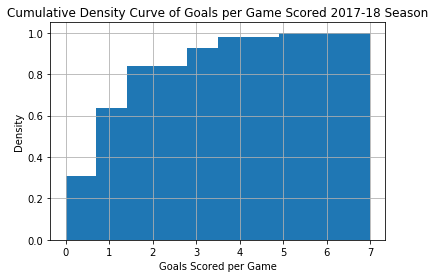

In [14]:
EPL_2017_2018_WL.Goals.hist(density=True, cumulative=True)
plt.title('Cumulative Density Curve of Goals per Game Scored 2017-18 Season')
plt.xlabel('Goals Scored per Game')
plt.ylabel('Density')

I use a histogram with a density to see the density distribution of goals allowed per game in 17/18 season. About 85% of the time, 2 or less goals are conceded by a team in a game.

Text(0,0.5,'Density')

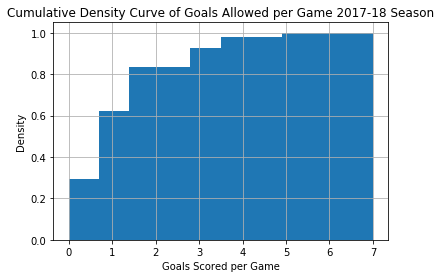

In [15]:
EPL_2017_2018_WL.GoalkeeperGoalsAgainst.hist(density=True, cumulative=True)
plt.title('Cumulative Density Curve of Goals Allowed per Game 2017-18 Season')
plt.xlabel('Goals Scored per Game')
plt.ylabel('Density')

I wanted to check the frequency of labels for goal against. I conclude that the data and therefore outcomes are imbalanced. There are way more games where a goal is scored as opposed to games where a goal is not scored

Text(0,0.5,'Frequency')

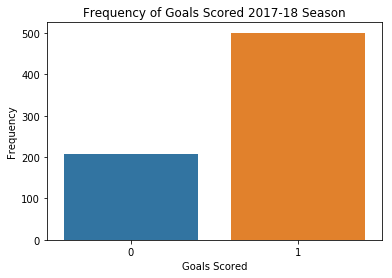

In [16]:
sns.countplot(x='goal_against_label',data=EPL_2017_2018_WL)
plt.title('Frequency of Goals Scored 2017-18 Season')
plt.xlabel('Goals Scored')
plt.ylabel('Frequency')

Visualization of the count by label for 2017/18 premier leagues season

Text(0,0.5,'Frequency')

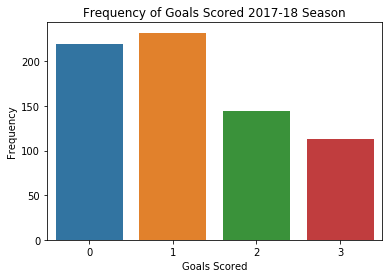

In [17]:
sns.countplot(x='goal_label',data=EPL_2017_2018_WL)
plt.title('Frequency of Goals Scored 2017-18 Season')
plt.xlabel('Goals Scored')
plt.ylabel('Frequency')

## REGRESSION ANALYSIS AND MODEL SELECTION FOR PREDICTIONS

### PREDICTING CLEAN SHEETS

After preparing my datasets, I run some classification to see how accurately I can predict clean sheets (i.e. a team concedes 0 goals)
The approach is as follows:
1. Start with 2015/16 data and split into train/test sets
2. Run various regression and classification models and find the best
3. Use the entire 2015/16 data as training set to check accuracy on the 2017-18 data.
4. Optimize the model 



I start by creating my X matrix (predictors) and Y(outcome). I split the dataset into test and train using the function below. I try:
    1. Logistic Regression
    2. Decision Tree
    3. Random Forest

In [18]:
X = EPL_2015_2016.drop(columns=['goal_against_label','goal_label','GA_unique_label'])
y = EPL_2015_2016['goal_against_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

I define my models here for each classifier

In [19]:
logreg = linear_model.LogisticRegression()
dectree = tree.DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=1)

I train a logistic regression model with the training set and make predictions with the test dataset. The outcome is 57.4% accuracy. More interestingly, 1 is easier and better to predict than 0. I create a confusion matrix to visualize the accuracy of different outcomes. 

In [20]:
logreg.fit(X_train,y_train)
y_predict = logreg.predict(X_test)
print(round(accuracy_score(y_test, y_predict),3))

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.568


,Predicted 0,Predicted 1
True 0,10,60
True 1,22,98


I train a decision tree with the training set and make predictions with the test dataset. The outcome is 53.2% accuracy. More interestingly, 1 is easier and better to predict than 0. I create a confusion matrix to visualize the accuracy of different outcomes. 

In [21]:
dectree.fit(X_train,y_train)
y_predict = dectree.predict(X_test)
print(round(accuracy_score(y_test, y_predict),3))
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.547


,Predicted 0,Predicted 1
True 0,27,43
True 1,43,77


I train a random forest classifier model with the training set and make predictions with the test dataset. The outcome is 61.1% accuracy. The random forest produces the best results for me. 

In [22]:
random_forest.fit(X_train,y_train)
y_predict = random_forest.predict(X_test)
print(round(accuracy_score(y_test, y_predict),3))
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.611


,Predicted 0,Predicted 1
True 0,8,62
True 1,12,108


I utilize the models on 2016/17 and 2017/18 data and results are consistent. Random forest is the best model. The accuracy is as follows:

LogReg - 0.72 

Decision Tree Classifier - 0.63

Random Forest - 0.72

#### Random Forest Performs best for all years. However, all the models are equally bad at predicting 0 goals while really good at predicting goals scored. I have narrowed the scope on to random forest and will to optimize the random forest

I first create a large training data set by combining the 2015/16 and 2016/17 data. With a large training dataset, I expect to train with a variety of outcomes.

In [23]:
big=EPL_2015_2016.append(EPL_2016_2017,ignore_index=True)
X_big = big.drop(columns=['goal_against_label','goal_label','GA_unique_label'])
y_big = big['goal_against_label']

In [24]:
print(len(X_big))
X1_train,X1_test,y1_train,y1_test=train_test_split(X_big,y_big,stratify=y_big)

1520


My test dataset will be the 2017/18 data

In [25]:
X_final = EPL_2017_2018.drop(columns=['goal_against_label','goal_label','GA_unique_label'])
y_final = EPL_2017_2018['goal_against_label']

Fitting the random forest to the 2017/18 data produces an accuracy of 67%. Here i try to use a set of parameters within the random forest classifier that would best predict the desired outcome.

In [26]:
forest = RandomForestClassifier(n_estimators=30, max_depth=5, random_state=42)
forest.fit(X1_train,y1_train)
y_predict = forest.predict(X1_test)
print(round(accuracy_score(y1_test, y_predict),3))
pd.DataFrame(
    confusion_matrix(y1_test, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.668


,Predicted 0,Predicted 1
True 0,6,117
True 1,9,248


The goal now is to optimize the random forest model. I start with feature selection to remove the undesired predictors and focus on the best possible set of predictors. This is also important as a less number of variables will make it easy for me to select players later. To do this, I use the RFE function within Sklearn library which essentially uses backward elimination to provide the predictors that best suit the model. It then provides me the support and ranking for the different predictors

In [27]:
rfe = RFE(forest)
rfe = rfe.fit(X_big,y_big)
print(rfe.support_)
print(rfe.ranking_)


[False False  True  True False False False False  True False False  True
  True  True False False False False  True  True  True  True  True]
[ 8  7  1  1  4  2  3  6  1  9  5  1  1  1 12 13 11 10  1  1  1  1  1]


I drop the False terms and continue with the selected terms. 

In [28]:
X1_big_new=X_big.iloc[:, [2,3,8,11,12,13,18,19,20,21,22]]
X1_big_new.head()


,CornersWon,Crosses,Interceptions,Passes,PassesCompleted,PenaltiesConceded,Shots,ShotsOnGoal,TacklesWon,Touches,YellowCards
0,1,4,33,385,302,0,7,0,13,0,0
1,7,12,18,763,689,0,13,5,12,0,1
2,10,32,7,618,551,0,19,5,18,0,2
3,3,13,14,376,305,0,21,11,18,0,1
4,4,13,20,454,375,0,5,2,10,0,1


I run the random forest again and get an accuracy of 66%, only 1% lower but way less predictors. I also noticed the impact of the number of estimators and max depth that i use. 

In [29]:
X1_train,X1_test,y1_train,y1_test=train_test_split(X1_big_new,y_big,stratify=y_big)
forest = RandomForestClassifier(n_estimators=30, max_depth=5, random_state=42)
forest.fit(X1_train,y1_train)
y_predict = forest.predict(X1_test)
print(round(accuracy_score(y1_test, y_predict),3))
pd.DataFrame(
    confusion_matrix(y1_test, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.703


,Predicted 0,Predicted 1
True 0,12,111
True 1,2,255


In [30]:
X1_final=X_final.iloc[:, [2,3,8,11,12,13,18,19,20,21,22]]

X1_final.head()

,CornersWon,Crosses,Interceptions,Passes,PassesCompleted,PenaltiesConceded,Shots,ShotsOnGoal,TacklesWon,Touches,YellowCards
12,0,7,18,401,294,0,14,5,18,618,0
13,4,22,20,626,539,0,14,3,13,857,1
62,7,14,13,985,908,0,21,7,15,1177,1
63,0,11,18,317,227,0,4,1,16,517,0
80,0,6,15,493,408,0,9,3,22,721,1


Now the objective is to optimize the paramters of the random forest classifier. I create a paramter grid with different values to test different combinations of parameters to see what gives me the best outcome  

In [ ]:
param_grid = { 
    'n_estimators': [10, 20, 30, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15, 20,30,50],
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf':[1,2,3,5,10] 
}

I run a grid search CV function which essentially allows me to find the most optimal paramter set. It runs through multiple combinations estimators, features, depth, criterion and min leaf samples to find the best model.

In [ ]:
CV_rfc = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5)
CV_rfc.fit(X1_big_new, y_big)

The following are found to be the best parameters based on my grid search model.

In [ ]:
CV_rfc.best_params_

I implement the new random classifier model with newly tuned parameters and the new accuracy is around 67%, only a 1% increase when tried on the train/test case.

In [31]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, criterion = 'entropy',
                               min_samples_leaf = 3, max_features = 'auto')
forest.fit(X1_train,y1_train)
y_predict = forest.predict(X1_test)
print(round(accuracy_score(y1_test, y_predict),3))
pd.DataFrame(
    confusion_matrix(y1_test, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.703


,Predicted 0,Predicted 1
True 0,12,111
True 1,2,255


I implement the new random classifier model with newly tuned parameters on the 2017/18 data and the new accuracy is around 71.6%, much better. This is better than a 50% accuracy expected with random guessing.

In [32]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, criterion = 'entropy',
                               min_samples_leaf = 3, max_features = 'auto')
forest.fit(X1_big_new,y_big)
y_predict = forest.predict(X1_final)
print(round(accuracy_score(y_final, y_predict),3))
pd.DataFrame(
    confusion_matrix(y_final, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.716


,Predicted 0,Predicted 1
True 0,27,180
True 1,21,480


However I notice that when I keep things "simple" and run the random forest with high estimators and low depth, I get a similar result.

In [33]:
forest1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest1.fit(X1_big_new,y_big)
y_predict = forest1.predict(X1_final)
print(round(accuracy_score(y_final, y_predict),3))
pd.DataFrame(
    confusion_matrix(y_final, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.722


,Predicted 0,Predicted 1
True 0,27,180
True 1,17,484


I plot one of the trees in the forest to visualize and observe. I utilize the graphviz library to create a visualization of the tree. 

In [ ]:
tree1=forest1.estimators_[1]

In [ ]:
dot_data = StringIO()
export_graphviz(tree1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X1_final.columns)

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Conclusion: with the random forest model, I can predict 72% of the time if a goal will be scored or not. The prediction is a lot easier for a case where a goal will be scored. This is a fascinating finding. I will now focus on how accurately I can predict the number of goals that will be conceded.

### Can I Classify Win/Loss

After completing my analysis, I realize that with all the findings I can actually try to classify a result in the game for the particular team based on their statistics. To do this I create a new label called result:
    1. Draw or Win - 1 is label
    2. Loss - 0 is label

In [52]:
pd.options.mode.chained_assignment = None
EPL_2015_2016_WL['Result']=[0]*len(EPL_2015_2016_WL)

EPL_2017_2018_WL['Result']=[0]*len(EPL_2017_2018_WL)
EPL_2017_2018_WL['Result'].head()

12    0
13    0
62    0
63    0
80    0
Name: Result, dtype: int64

This is a function to append the result label for different seasons.

In [53]:
def result(df):
    for i in range(len(df)):
        pd.options.mode.chained_assignment = None
        if ((df['Goals'].iloc[i])<(df['GoalkeeperGoalsAgainst'].iloc[i])):
            df['Result'].iloc[i]=0
        else:
            df['Result'].iloc[i]=1        

In [54]:
result(EPL_2015_2016_WL)

result(EPL_2017_2018_WL)


In [55]:
EPL_2015_2016_WL[['Result','Goals','GoalkeeperGoalsAgainst']].head()


,Result,Goals,GoalkeeperGoalsAgainst
0,1,0,0
1,1,3,1
2,0,1,5
3,1,5,1
4,0,0,4


In [56]:
EPL_2017_2018_WL[['Result','Goals','GoalkeeperGoalsAgainst']].head()


,Result,Goals,GoalkeeperGoalsAgainst
12,0,0,2
13,1,2,0
62,1,3,1
63,0,1,4
80,0,1,2


I create the X and y data frames for the models. I create a train and test dataset. 

In [58]:
X_WL = EPL_2015_2016_WL.drop(columns=['goal_against_label','goal_label','GA_unique_label','Goals',
                                   'GoalkeeperGoalsAgainst','Result'])
y_WL = EPL_2015_2016_WL['Result']

X_WL_17 = EPL_2017_2018_WL.drop(columns=['goal_against_label','goal_label','GA_unique_label','Goals',
                                   'GoalkeeperGoalsAgainst','Result'])
y_WL_17 = EPL_2017_2018_WL['Result']

X_train, X_test, y_train, y_test = train_test_split(X_WL, y_WL,stratify=y_WL)

array(X_WL.columns.values)

array(['Assists', 'BlockedShots', 'CornersWon', 'Crosses', 'Fouled',
       'Fouls', 'GoalkeeperSaves', 'Interceptions', 'LastManTackle',
       'Offsides', 'Passes', 'PassesCompleted', 'PenaltiesConceded',
       'PenaltiesWon', 'PenaltyKickMisses', 'PenaltyKickSaves',
       'RedCards', 'Shots', 'ShotsOnGoal', 'TacklesWon', 'Touches',
       'YellowCards'], dtype=object)

Once I create my test and train data, I run the following models to predict outcomes:
    1. Logistic Regression
    2. Random Forest

The logistic regression produces an accuracy of 74% for the outcomes

In [59]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)
y_predict = logreg.predict(X_test)
print(round(accuracy_score(y_test, y_predict),3))

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.737


,Predicted 0,Predicted 1
True 0,29,32
True 1,18,111


The random forest produces an accuracy of 70% for the outcomes

In [60]:
random_forest = RandomForestClassifier(n_estimators=60, max_depth=30, random_state=1,criterion='entropy')
random_forest.fit(X_train,y_train)
y_predict = random_forest.predict(X_test)
print(round(accuracy_score(y_test, y_predict),3))
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.716


,Predicted 0,Predicted 1
True 0,22,39
True 1,15,114


Since the logistic model produces the best result, I try now to optimize it using feature selection.

In [61]:
rfe = RFE(logreg)
rfe = rfe.fit(X_WL,y_WL)
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True False  True False  True  True False False False
 False False  True  True  True  True  True False False False]
[ 1  4  1  1  6  1  2  1  1  9  8  7 11 12  1  1  1  1  1  3 10  5]


In [62]:
rfe = RFE(random_forest)
rfe = rfe.fit(X_WL,y_WL)
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True  True  True False  True False False  True  True
 False False False False False  True  True  True False False]
[ 1  3  1  1  1  1  2  1  7  4  1  1 11 10  9  8  6  1  1  1 12  5]


I then create the new dataframes with the newly selected features

In [63]:
X_WL_log=X_WL.iloc[:, [0,2,3,5,7,8,14,15,16,17,18]]
X_WL_rfc=X_WL.iloc[:, [0,2,3,4,5,7,10,11,17,18,19]]
X_WL_17_log=X_WL_17.iloc[:, [0,2,3,5,7,8,14,15,16,17,18]]
X_WL_17_rfc=X_WL_17.iloc[:, [0,2,3,4,5,7,10,11,17,18,19]]

In [64]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

I run the results for the logistic regression fit to get the P values for all the different features. Some variables have a p-value greater than 0.05, I drop them and reevaluate the model

In [65]:
import statsmodels.api as sm
logit_model=sm.Logit(y_WL_17,X_WL_17_log)
result=logit_model.fit()
print(result.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.506973
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Result   No. Observations:                  708
Model:                          Logit   Df Residuals:                      697
Method:                           MLE   Df Model:                           10
Date:                Fri, 11 May 2018   Pseudo R-squ.:                  0.2341
Time:                        15:51:46   Log-Likelihood:                -358.94
converged:                       True   LL-Null:                       -468.64
                                        LLR p-value:                 1.421e-41
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Assists               1.0023      0.137      7.331      0.000       0.734       1.270
CornersW

I removed the variables that had a P-value higher than 0.05 and created a new X matrix with only 5 predictors

In [66]:
X_WL_log_new=X_WL_log.iloc[:, [0,2,4,8,9]]
X_WL_17_log_new=X_WL_17_log.iloc[:, [0,2,4,8,9]]
X_WL_17_log_new.head()

,Assists,Crosses,Interceptions,RedCards,Shots
12,0,7,18,0,14
13,2,22,20,0,14
62,3,14,13,0,21
63,0,11,18,0,4
80,1,6,15,0,9


I run the model on the 2017 data to test my predictions against the real outcomes. I get around a 69% accuracy.

In [67]:
logreg.fit(X_WL_log,y_WL)
y_predict = logreg.predict(X_WL_17_log)
print(round(accuracy_score(y_WL_17, y_predict),3))

pd.DataFrame(
    confusion_matrix(y_WL_17, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.689


,Predicted 0,Predicted 1
True 0,121,145
True 1,75,367


I then run the new logit model with 5 predictors on the 2017 data to test my predictions against the real outcomes. I get around a 70% accuracy. 70% with 5 predictors is a perfect balance to help me find players

In [68]:
logreg.fit(X_WL_log_new,y_WL)
y_predict = logreg.predict(X_WL_17_log_new)
print(round(accuracy_score(y_WL_17, y_predict),3))

pd.DataFrame(
    confusion_matrix(y_WL_17, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.701


,Predicted 0,Predicted 1
True 0,116,150
True 1,62,380


In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_WL_17, y_predict))

             precision    recall  f1-score   support

          0       0.65      0.44      0.52       266
          1       0.72      0.86      0.78       442

avg / total       0.69      0.70      0.68       708



I created a ROC curve to visualize my binary classifer model. The dotted line represents the ROC curve of a random classifier while the blue line represents the current model. The current model is much further from the random classifier.

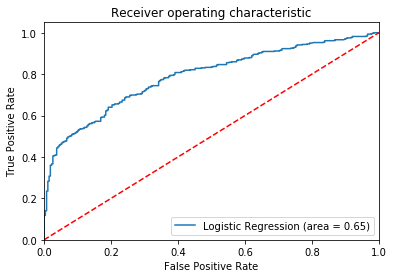

In [70]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_WL_17, y_predict)
fpr, tpr, thresholds = roc_curve(y_WL_17, logreg.predict_proba(X_WL_17_log_new)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

I also run a random forest with the 5 predictors and receive a 71% accuracy. 

In [71]:
random_forest = RandomForestClassifier(n_estimators=200, max_depth=100, random_state=1,criterion='entropy')
random_forest.fit(X_WL_rfc,y_WL)
y_predict = random_forest.predict(X_WL_17_rfc)
print(round(accuracy_score(y_WL_17, y_predict),3))

pd.DataFrame(
    confusion_matrix(y_WL_17, y_predict),
    columns=['Predicted 0', 'Predicted 1'],
    index=['True 0', 'True 1'])

0.713


,Predicted 0,Predicted 1
True 0,133,133
True 1,70,372


I visualize one of the trees from the random forest to visualize cutoff values

I wanted to create a frequency plot of the results in comparison to the amount of goals scored. It is interesting to see that majority of the time, scoring 1 or 2 goals 

Text(0,0.5,'Frequency of Goals')

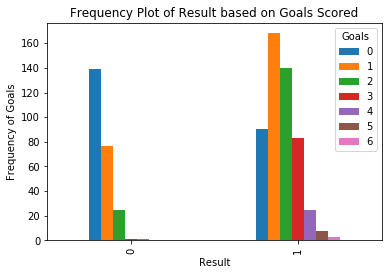

In [73]:
pd.crosstab(EPL_2015_2016_WL.Result,EPL_2015_2016_WL.Goals).plot(kind='bar')
plt.title('Frequency Plot of Result based on Goals Scored')
plt.xlabel('Result')
plt.ylabel('Frequency of Goals')

Below is a frequency plot of the results in comparison to the amount of goals conceded. It is interesting to see that teams are still able to get a positive result after conceding upto 2 goals!

Text(0,0.5,'Frequency of Goals Allowed')

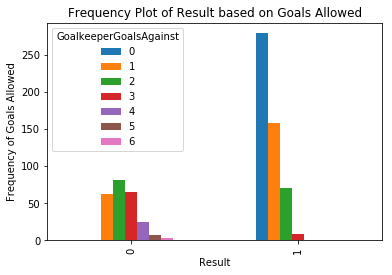

In [74]:
pd.crosstab(EPL_2015_2016_WL.Result,EPL_2015_2016_WL.GoalkeeperGoalsAgainst).plot(kind='bar')
plt.title('Frequency Plot of Result based on Goals Allowed')
plt.xlabel('Result')
plt.ylabel('Frequency of Goals Allowed')

# Player Selection for Better Results

My goal now is to do a player selection using player statistics from the 2017-18 season. Players that maximize the newly developed model are required. I use the logit model with 5 predictor variables that I create in the section above.

In [75]:
array(X_WL_log_new.columns.values)

array(['Assists', 'Crosses', 'Interceptions', 'RedCards', 'Shots'],
      dtype=object)

I run a binomial regression similar to the one in the section above to create my logit model

In [76]:
import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as stat
logit_model=sm.Logit(y_WL_17,X_WL_17_log_new)
#player_model=sm.GLM(y_WL_17,X_WL_17_log_new,sm.families.Binomial())
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.511137
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Result   No. Observations:                  708
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 May 2018   Pseudo R-squ.:                  0.2278
Time:                        15:52:04   Log-Likelihood:                -361.89
converged:                       True   LL-Null:                       -468.64
                                        LLR p-value:                 4.664e-45
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Assists           1.0756      0.128      8.405      0.000       0.825       1.326
Crosses          -0.

I then use the csv file i created from the API to get the player info and visualize the player column labels

In [77]:
players=pd.read_csv('Players_EPL_17_18.csv')

I keep only the 5 predictor variables of interest. Since the player results are aggregated over the season, I create new columns with the averages of the stats. The average is dependent on the number of games played (Started column)

In [79]:
players=players[['Name','Assists','Crosses','Interceptions','RedCards','Shots','Team','Started',
                 'Position']]
players[['Assists']]=players[['Assists']].astype('int')
players['Assists_Avg']=players['Assists']/players['Started']
players[['Crosses']]=players[['Crosses']].astype('int')
players['Crosses_Avg']=players['Crosses']/players['Started']
players[['Interceptions']]=players[['Interceptions']].astype('int')
players['Interceptions_Avg']=players['Interceptions']/players['Started']
players[['RedCards']]=players[['RedCards']].astype('int')
players['RedCards_Avg']=players['RedCards']/players['Started']
players[['Shots']]=players[['Shots']].astype('int')
players['Shots_Avg']=players['Shots']/players['Started']


I do some data cleaning in this section. I remove any players with null values or any players that have not played at least 10 games in the season

In [80]:
players=players.dropna(axis=0,how='any')
players_final=players.loc[players['Started']>10]

I save the data to a csv for later use

In [81]:
players_final.to_csv('players_final.csv')

In [82]:
players_final.head()

,Name,Assists,Crosses,Interceptions,RedCards,Shots,Team,Started,Position,Assists_Avg,Crosses_Avg,Interceptions_Avg,RedCards_Avg,Shots_Avg
1,Nacho Monreal,2,37,66,0,23,Arsenal FC,26,D,0.076923,1.423077,2.538462,0.0,0.884615
2,Alex Oxlade-Chamberlain,7,95,34,0,53,Liverpool FC,17,M,0.411765,5.588235,2.000000,0.0,3.117647
3,Aaron Ramsey,7,16,24,0,59,Arsenal FC,19,M,0.368421,0.842105,1.263158,0.0,3.105263
4,Héctor Bellerín,1,69,29,0,31,Arsenal FC,32,D,0.031250,2.156250,0.906250,0.0,0.968750
5,Laurent Koscielny,0,6,68,0,10,Arsenal FC,25,D,0.000000,0.240000,2.720000,0.0,0.400000


I write a function which is essentially the logit model and calculate the probability of success for each player.

In [83]:
def points(a,b,c,d,e):
    A=(exp(1.0756*a - 0.0517*b - 0.05*c - 1.2381*d + 0.123*e)/
    (1 + exp((1.0756*a - 0.0517*b - 0.05*c - 1.2381*d + 0.123*e))))
    return A

I run the points function on the players data

In [84]:
players_final['Points']=points(players_final.Assists_Avg,players_final.Crosses_Avg,players_final.Interceptions_Avg,
       players_final.RedCards_Avg,players_final.Shots_Avg)

I store the Name, Position, Team and Points of the players in a new dataframe and sort them by points

In [85]:
Player_Model=players_final[['Name','Position','Team','Points']].sort_values(by=['Points'],ascending=False)

Best 10 Attackers of the 2017-18 Season. I am fascinated to see Benteke on this list and Rashford as the best Man United attacker!

In [86]:
Player_Model.loc[Player_Model['Position']=="A"].head(10)

,Name,Position,Team,Points
97,Sergio Agüero,A,Manchester City FC,0.696105
100,Raheem Sterling,A,Manchester City FC,0.693325
326,Harry Kane,A,Tottenham Hotspur FC,0.682254
194,Álvaro Morata,A,Chelsea FC,0.662099
220,Gabriel Jesus,A,Manchester City FC,0.635655
92,Christian Benteke,A,Crystal Palace FC,0.630696
309,Marcus Rashford,A,Manchester United FC,0.630633
308,Anthony Martial,A,Manchester United FC,0.628193
294,Romelu Lukaku,A,Manchester United FC,0.626859
10,Danny Welbeck,A,Arsenal FC,0.623708


Best 10 Midfielders of the 2017-18 Season. As expected, the best players show up, but its interesting to see Alex Iwobi and Dominic Calvert-Lewin on this list.

In [87]:
Player_Model.loc[Player_Model['Position']=="M"].head(10)

,Name,Position,Team,Points
439,Philippe Coutinho,M,Liverpool FC,0.683739
190,Mohamed Salah,M,Liverpool FC,0.682976
350,Paul Pogba,M,Manchester United FC,0.675582
3,Aaron Ramsey,M,Arsenal FC,0.661845
185,Leroy Sané,M,Manchester City FC,0.660980
258,Dominic Calvert-Lewin,M,Everton FC,0.642752
335,Dele Alli,M,Tottenham Hotspur FC,0.640633
94,David Silva,M,Manchester City FC,0.635636
349,Henrikh Mkhitaryan,M,Arsenal FC,0.634539
8,Alex Iwobi,M,Arsenal FC,0.624033


Best 10 Defenders of the 2017-18 Season. As expected, teams that defend a lot will have players that show up on this. However, its interesting to see 3 Man City Defenders on this list

In [88]:
Player_Model.loc[Player_Model['Position']=="D"].head(10)

,Name,Position,Team,Points
203,Danilo,D,Manchester City FC,0.547819
35,Wilfred Ndidi,D,Leicester City FC,0.539823
30,Sead Kolašinac,D,Arsenal FC,0.536282
395,Cheikhou Kouyaté,D,West Ham United FC,0.529894
154,Kyle Walker,D,Manchester City FC,0.528242
359,Florian Lejeune,D,Newcastle United FC,0.526372
251,Kevin Long,D,Burnley FC,0.526026
93,Vincent Kompany,D,Manchester City FC,0.520389
131,Ryan Shawcross,D,Stoke City FC,0.520214
332,Eric Dier,D,Tottenham Hotspur FC,0.519618


Conclusion: Using the logit model for player selection, the ideal team formation (4-4-2) barring goalkeeper would be the following.
Right Back - Danilo

Center Back - Cheikhou Kouyate

Center Back - Wilfred Ndidi

Left Back - Sead Kolasinac

Right Mid - Mo Salah

Center Mid - Aaron Ramsey

Center Mid - Paul Pogba

Left Mid - Phillipe Coutinho

Striker - Sergio Aguero

Striker - Raheem Sterling
    

# NEXT STEPS AND APPENDIX

### Now I'll try to predict the number of goals allowed as a discrete

The goal here is to see if I can accurately predict the number of goals that a team will concede. For this I use:

1. Multinomial Regression
2. Random Forest

The predictor variable in this case is different. I utilize the goal against unique label which has a different class label depending on the number of goals conceded:
    1. 0 for 0 conceded
    2. 1 for 1 conceded
    3. 2 for 2 conceded
    4. 3 for 3+ conceded

In [34]:
y_unique = big['GA_unique_label']

y_final_unique = EPL_2017_2018['GA_unique_label']


I then run a multinomial regression model since the outcomes are multi-class. I create a train and test dataset using the "big dataset" (2015 and 16 seasons data) and then gather predictions. Result are poor, only around 38% accuracy for the number of goals scored predicted. Random guessing would be a 25% accuracy so this model is better.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X1_big_new, y_unique, stratify=y_unique)
multi=linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
multi.fit(X_train,y_train)
y_predict = multi.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predict))

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],
    index=['True 0', 'True 1','True 2','True 3'])

0.3631578947368421


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
True 0,78,38,2,5
True 1,63,44,5,5
True 2,33,35,2,7
True 3,26,22,1,14


I then run a random forest since the outcomes are multi-class. I create a train and test dataset using the "big dataset" (2015 and 16 seasons data) and then gather predictions. Result are poor, only around 31% accuracy for the number of goals scored predicted. 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X1_big_new, y_unique,stratify=y_unique)
forest2 = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42)
forest2.fit(X_train,y_train)
y_predict = forest2.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predict))

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],
    index=['True 0', 'True 1','True 2','True 3'])

0.3236842105263158


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
True 0,58,49,9,7
True 1,46,45,18,8
True 2,30,29,9,9
True 3,21,26,5,11


I then run the multinomial regression model I created to test the model predictions versus the real outcomes. I am able to predict with a 40% accuracy. This is better than random guessing of 25% accuracy. 

In [37]:
multi=linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
multi.fit(X1_big_new,y_unique)
y_predict = multi.predict(X1_final)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_final_unique, y_predict))

pd.DataFrame(
    confusion_matrix(y_final_unique, y_predict),
    columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],
    index=['True 0', 'True 1','True 2','True 3'])

0.3926553672316384


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
True 0,119,67,3,18
True 1,93,113,3,25
True 2,59,69,3,19
True 3,30,43,1,43


In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_final_unique, y_predict))

             precision    recall  f1-score   support

          0       0.40      0.57      0.47       207
          1       0.39      0.48      0.43       234
          2       0.30      0.02      0.04       150
          3       0.41      0.37      0.39       117

avg / total       0.37      0.39      0.35       708



I then run the random forest model I created to test the model predictions versus the real outcomes. I am able to predict with a 33% accuracy. This is better than random guessing of 25% accuracy. 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X1_big_new, y_unique,stratify=y_unique)
forest2 = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42,criterion='entropy')
forest2.fit(X1_big_new,y_unique)
y_predict = forest2.predict(X1_final)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_final_unique, y_predict))

pd.DataFrame(
    confusion_matrix(y_final_unique, y_predict),
    columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],
    index=['True 0', 'True 1','True 2','True 3'])

0.326271186440678


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
True 0,98,63,31,15
True 1,90,83,32,29
True 2,42,56,31,21
True 3,29,44,25,19


The conclusion from this analysis is that the multinomial regression is a much better model to predict the "actual" number of goals allowed. However the accuracy is only 40%. The accuracy is different for different classes however.

### Now I'll try to predict the number of goals scored 

I also wanted to explore if I could explore whether I could predict the outcome for the number of goals. I use multinomial logistic regression and random forest to determine the outcome. For this, I use a new label for the y called the "goal_label" which I created earlier.   

In [40]:
y_goals = big['goal_label']

y_final_goals = EPL_2017_2018['goal_label']

I run the multinomial regression model on the test and compare outcomes with the training data.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X1_big_new, y_goals, stratify=y_unique)
multi=linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
multi.fit(X_train,y_train)
y_predict = multi.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predict))

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],
    index=['True 0', 'True 1','True 2','True 3'])

0.4421052631578947


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
True 0,73,43,0,3
True 1,45,53,6,13
True 2,14,42,6,17
True 3,1,22,6,36


I run the random forest model on the test and compare outcomes with the training data.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X1_big_new, y_goals,stratify=y_unique)
forest2 = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42,criterion='entropy')
forest2.fit(X_train,y_train)
y_predict = forest2.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predict))

pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],
    index=['True 0', 'True 1','True 2','True 3'])

0.4


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
True 0,49,37,9,6
True 1,39,49,11,13
True 2,18,37,16,20
True 3,0,17,21,38


I then run the multinomial model to get the predictions and compare with real outputs for the 2017-18 season.The accuracy is around 48% significantly higher than 25% accuracy on a random guess. 

In [43]:
multi=linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
multi.fit(X1_big_new,y_goals)
y_predict = multi.predict(X1_final)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_final_goals, y_predict))

pd.DataFrame(
    confusion_matrix(y_final_goals, y_predict),
    columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],
    index=['True 0', 'True 1','True 2','True 3'])

0.481638418079096


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
True 0,142,63,11,3
True 1,92,95,21,24
True 2,16,75,27,26
True 3,0,24,12,77


I then run the random forest model to get the predictions and compare with real outputs for the 2017-18 season.The accuracy is around 44% significantly higher than 25% accuracy on a random guess. 

In [44]:
forest2 = RandomForestClassifier(n_estimators=50, max_depth=100, random_state=42,criterion='entropy')
forest2.fit(X1_big_new,y_goals)
y_predict = forest2.predict(X1_final)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_final_goals, y_predict))

pd.DataFrame(
    confusion_matrix(y_final_goals, y_predict),
    columns=['Predicted 0', 'Predicted 1','Predicted 2','Predicted 3'],
    index=['True 0', 'True 1','True 2','True 3'])

0.442090395480226


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
True 0,126,55,28,10
True 1,81,86,35,30
True 2,22,45,35,42
True 3,1,19,27,66
